## **Timeline Filtering**

In [1]:
import pandas as pd
import re
import pyarrow

In [2]:
import time
import math
import re
# import textblob
# from textblob import TextBlob
import pandas as pd
import numpy as np

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import string
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.utils import simple_preprocess
pyLDAvis.enable_notebook()

In [3]:
# Imports the Google Cloud client library
from google.cloud import storage
# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = "nlp_final_project_kshitijm"

# Creates the new bucket
bucket = storage_client.bucket(bucket_name)
print(f"Bucket {bucket.name} connected.")

Bucket nlp_final_project_kshitijm connected.


In [4]:
# %pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

num_processors = multiprocessing.cpu_count()
workers = num_processors-1

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Graphics in SVG format are more sharp and legible
# %config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings("ignore")

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

---
### **Loading Data**

In [5]:
%%time
df3_full=pd.read_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data31_tokens.parquet')

In [6]:
%%time
df3_2020=pd.read_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data3_2020.parquet')

CPU times: user 4.48 s, sys: 1.53 s, total: 6.01 s
Wall time: 7.35 s


In [7]:
%%time
df3_2021=pd.read_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data3_2021.parquet')

CPU times: user 5.88 s, sys: 2.12 s, total: 7.99 s
Wall time: 8.95 s


In [8]:
%%time
df3_2022=pd.read_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data3_2022.parquet')

CPU times: user 6.74 s, sys: 2.4 s, total: 9.15 s
Wall time: 13 s


In [9]:
%%time
df3_2023=pd.read_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data3_2023.parquet')

CPU times: user 7.08 s, sys: 2.91 s, total: 9.99 s
Wall time: 10.7 s


### Seeing spread of articles across time

In [12]:
df3_full.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1, inplace=True)
df3_full.columns

Index(['url', 'date', 'language', 'title', 'text', 'cleaned_text',
       'article_source', 'clean_title', 'title_tokens', 'cleaned_text_tokens',
       'year_pub'],
      dtype='object')

In [14]:
df3_full.head(2)

,url,date,language,title,text,cleaned_text,article_source,clean_title,title_tokens,cleaned_text_tokens,year_pub
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,en,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,Artificial intelligence improves parking effi...,People's Daily Online,Artificial intelligence improves parking effic...,"['artificial', 'intelligence', 'improves', 'pa...","['artificial', 'intelligence', 'improves', 'pa...",2021
1,http://newsparliament.com/2020/02/27/children-...,2020-02-27,en,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,Children With Autism Saw Their Learning and S...,News Parliament,Children With Autism Saw Their Learning and So...,"['children', 'autism', 'saw', 'learning', 'soc...","['children', 'autism', 'saw', 'learning', 'soc...",2020


In [17]:
df3_full['month']=df3_full['date'].dt.month
df3_full['month-year']=df3_full['date'].dt.strftime('%b %Y')
df3_full.head(2)

,url,date,language,title,text,cleaned_text,article_source,clean_title,title_tokens,cleaned_text_tokens,year_pub,month,month-year
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,en,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,Artificial intelligence improves parking effi...,People's Daily Online,Artificial intelligence improves parking effic...,"['artificial', 'intelligence', 'improves', 'pa...","['artificial', 'intelligence', 'improves', 'pa...",2021,3,Mar 2021
1,http://newsparliament.com/2020/02/27/children-...,2020-02-27,en,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,Children With Autism Saw Their Learning and S...,News Parliament,Children With Autism Saw Their Learning and So...,"['children', 'autism', 'saw', 'learning', 'soc...","['children', 'autism', 'saw', 'learning', 'soc...",2020,2,Feb 2020


In [28]:
articles_period=df3_full.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
articles_period.rename(columns={'url':'count_articles'}, inplace=True)

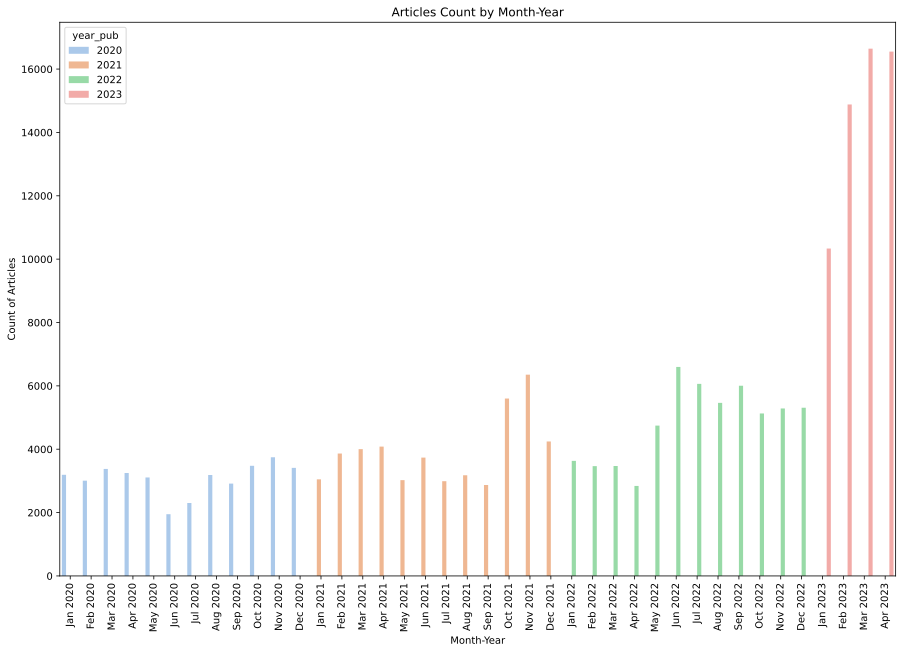

In [47]:
fig,axes=plt.subplots(figsize=(15, 10))
sns.barplot(x=articles_period['month-year'],y=articles_period['count_articles'], ax=axes, hue=articles_period['year_pub'], palette='pastel', linewidth=5)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('Month-Year')
plt.ylabel('Count of Articles')
plt.title('Articles Count by Month-Year')

# Show the plot
plt.show()


Count of articles is shooting up tremendously in 2023

----
### Checking for duplicates

In [48]:
df3_full.head(2)

,url,date,language,title,text,cleaned_text,article_source,clean_title,title_tokens,cleaned_text_tokens,year_pub,month,month-year
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,en,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,Artificial intelligence improves parking effi...,People's Daily Online,Artificial intelligence improves parking effic...,"['artificial', 'intelligence', 'improves', 'pa...","['artificial', 'intelligence', 'improves', 'pa...",2021,3,Mar 2021
1,http://newsparliament.com/2020/02/27/children-...,2020-02-27,en,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,Children With Autism Saw Their Learning and S...,News Parliament,Children With Autism Saw Their Learning and So...,"['children', 'autism', 'saw', 'learning', 'soc...","['children', 'autism', 'saw', 'learning', 'soc...",2020,2,Feb 2020


URL Does not have any duplicates

In [51]:
has_duplicates_url = df3_full['url'].duplicated().any()
has_duplicates_url

False

---
Both titles and texts have some duplicate entries  

In [54]:
has_duplicates_title = df3_full['clean_title'].duplicated().any()
has_duplicates_title

True

In [57]:
duplicates_title = df3_full[df3_full['clean_title'].duplicated()]
len(duplicates_title)

82991

When checking for duplicated titles, we see that ~80K articles have duplicated titles. 
We can aim to retain these, as the same articles might be getting reported from different news sources

In [53]:
has_duplicates_url = df3_full['cleaned_text'].duplicated().any()
has_duplicates_url

True

In [58]:
duplicates_text = df3_full[df3_full['cleaned_text'].duplicated()]
len(duplicates_text)

1959

~2000 articles have the exact same text composition. This is an anomaly, because the text in its entirely being same does imply complete repetition of the articles

In [61]:
df3_full=df3_full.sort_values(by=['year_pub','month'])
df4_full = df3_full.drop_duplicates(subset='cleaned_text', keep='last') # Keeping the latest article
df4_full.shape

(198373, 13)

In [63]:
df4_full.head(2)

,url,date,language,title,text,cleaned_text,article_source,clean_title,title_tokens,cleaned_text_tokens,year_pub,month,month-year
99,https://fusionscienceacademy.com/artificial-in...,2020-01-30,en,Artificial Intelligence (AI) in Social Media ...,\n\nArtificial Intelligence (AI) in Social Med...,Artificial Intelligence AI in Social MediaMar...,2026 – Fusion Science Academy,Artificial Intelligence (AI) in Social Media ...,"['artificial', 'intelligence', 'ai', 'social',...","['artificial', 'intelligence', 'ai', 'social',...",2020,1,Jan 2020
115,https://health.economictimes.indiatimes.com/ne...,2020-01-10,en,artificial intelligence: Researchers develop A...,\n\nartificial intelligence: Researchers devel...,artificial intelligence: Researchers develop ...,None,artificial intelligence: Researchers develop A...,"['artificial', 'intelligence', 'researchers', ...","['artificial', 'intelligence', 'researchers', ...",2020,1,Jan 2020


----
### Filtering out irrelevant articles

In [65]:
pd.options.display.max_colwidth=1000
df4_full['cleaned_text_tokens']

99        ['artificial', 'intelligence', 'ai', 'social', 'mediamarket', 'witness', 'slow', 'growth', 'owing', 'unfavorable', 'government', 'policies', 'fusion', 'science', 'academyour', 'writersus', 'terms', 'conditionsjoin', 'usfusion', 'science', 'academy', 'artificial', 'intelligence', 'ai', 'social', 'mediamarket', 'witness', 'slow', 'growth', 'owing', 'unfavorable', 'government', 'policies', 'market', 'forecast', 'market', 'size', 'industry', 'growth', 'industry', 'trends', 'market', 'report', 'market', 'share', 'key', 'players', 'global', 'market', 'market', 'sales', 'industry', 'analysis', 'market', 'outlookusmarket', 'report', 'artificial', 'intelligence', 'ai', 'social', 'mediamarket', 'witness', 'slow', 'growth', 'owing', 'unfavorable', 'government', 'policies', 'published', 'seconds', 'ago', 'january', 'report', 'global', 'artificial', 'intelligence', 'ai', 'social', 'media', 'market', 'tmr', 'analysts', 'tmr', 'global', 'artificial', 'intelligence', 'ai', 'social', 'media',

In [93]:
tops_relevant=['artificial','intelligence','machine','ai','ml','data','chatgpt','openai','llm','analytics','gpt']

In [94]:
%%time
df4_full['flag_relevant']=df4_full['cleaned_text_tokens'].apply(lambda x : 1 if any(any_word in x for any_word in tops_relevant) else 0)
df4_full['flag_relevant'].value_counts()

CPU times: user 1.72 s, sys: 0 ns, total: 1.72 s
Wall time: 1.71 s


1    197730
0       643
Name: flag_relevant, dtype: int64

In [99]:
pd.options.display.max_colwidth=1000
df4_full[df4_full['flag_relevant']==0][['cleaned_text','cleaned_text_tokens']].tail(3)

,cleaned_text,cleaned_text_tokens
193530,"Derek Bard P TOUR Player Profile, Stats, Bio, CareerLeaderboardWatchNewsFortinet CupSchedulePlayersStatsShopP TOURP TOUR ChampionsKorn Ferry TourP TOUR P TOUR LatinoamricaLP TOURDP World TourP TOUR UniversityLoading...THE TOURAboutCareersTPC NetworkPartnershipMarketing PartnersAffiliateInternationalMediaQuick LinksBirdies Fore LoveImpactESPNShopFan ShopSuperstoreTicketsAppsP TOURP TOUR FantasyP TOUR Terms of ServiceAccessibility StatementDo Not Sell or Share My Personal Information ChoicesSitemap2023 P TOUR, . .P TOUR, P TOUR Champions, and the Swinging Golfer design are registered trademarks. The Korn Ferry trademark is also a registered trademark, and is used in the Korn Ferry Tour logo with permission.","['derek', 'bard', 'pga', 'tour', 'canada', 'player', 'profile', 'stats', 'bio', 'tourpga', 'tour', 'championskorn', 'ferry', 'tourpga', 'tour', 'canadapga', 'tour', 'tourdp', 'world', 'tourpga', 'tour', 'linksbirdies', 'fore', 'tourpga', 'tour', 'fantasypga', 'tour', 'arterms', 'statementdo', 'sell', 'share', 'personal', 'information', 'choicessitemap', 'pga', 'tour', 'pga', 'tour', 'pga', 'tour', 'champions', 'swinging', 'golfer', 'design', 'registered', 'trademarks', 'korn', 'ferry', 'trademark', 'registered', 'trademark', 'korn', 'ferry', 'tour', 'logo', 'permission']"
71259,"New Bard High School Early College Slated to Open in South BronxOpen in AppSign inAnnandaleonhudsonChange locationAnnandaleonhudsonChange locationLOLTop StoriesSafetyFoodDrinkSportsSee moreADDITION NTENational NewsWSBRE RPATEContributorsPublishersAdvertisersTerms of Use Do Not SellShare My Info Help CenterSign inAnnandaleonhudson, See more from this locationbard.eduNew Bard High School Early College Slated to Open in South Bronx8 days ago8 days agoGo to Publishers websiteRead in NewsBreakComments0Add a CommentYOU Y SO LIKETerms of Use Do Not SellShare My Info Help CenterComments0Community PolicyOur updatedwent into effect Jan. 1, 2023.","['new', 'bard', 'high', 'school', 'early', 'college', 'slated', 'open', 'south', 'bronxopen', 'appsign', 'moreadditional', 'contentnational', 'newsnewsbreak', 'use', 'sellshare', 'info', 'help', 'centersign', 'nysee', 'locationbard', 'edunew', 'bard', 'high', 'school', 'early', 'college', 'slated', 'open', 'south', 'bronx', 'days', 'ago', 'days', 'agogo', 'publishers', 'websiteread', 'add', 'commentyou', 'liketerms', 'use', 'sellshare', 'info', 'help', 'centercomments', 'community', 'policyour', 'updatedwent', 'effect', 'jan']"
40641,"Free My Favorite Person by Stephen Bard sheet musicDownload PDF or print onAbout MusescoreAboutJobsusOur ProductsMuseScore PROGiftsCommunityOur Ethical LineReport abuseCommunity GuidelinesScore Uploading GuidelinesCommunitySoftwareDownloadHandbookForumHelp centerMoreLicensingTerms of UseDMPricingSocialYouTubeFacebookTwitterLinkedInContentTop ScoresNew ScoresAll ArtistsScores CategoriesCoursesOur products2023 MuseScore LtdSpyrou Kyprianou 84,4004 Limassol,","['free', 'favorite', 'person', 'stephen', 'bard', 'sheet', 'musicdownload', 'pdf', 'print', 'onabout', 'ethical', 'linereport', 'abusecommunity', 'guidelinesscore', 'uploading', 'scoresnew', 'scoresall', 'artistsscores', 'products', 'musescore', 'ltdspyrou', 'kyprianou', 'limassol', 'cyprus']"


Removing these 643 irrelevant articles

In [101]:
df4_full=df4_full[df4_full.flag_relevant==1]
df4_full.shape

(197730, 14)

----
### Now inspecting number of tokens
While tokenizing, we removed words greater than length 15 and stopwords

In [103]:
df4_full['num_tokens']=df4_full['cleaned_text_tokens'].apply(lambda x: len(x))
df4_full[['cleaned_text_tokens','num_tokens']].head(3)

,cleaned_text_tokens,num_tokens
99,"['artificial', 'intelligence', 'ai', 'social', 'mediamarket', 'witness', 'slow', 'growth', 'owing', 'unfavorable', 'government', 'policies', 'fusion', 'science', 'academyour', 'writersus', 'terms', 'conditionsjoin', 'usfusion', 'science', 'academy', 'artificial', 'intelligence', 'ai', 'social', 'mediamarket', 'witness', 'slow', 'growth', 'owing', 'unfavorable', 'government', 'policies', 'market', 'forecast', 'market', 'size', 'industry', 'growth', 'industry', 'trends', 'market', 'report', 'market', 'share', 'key', 'players', 'global', 'market', 'market', 'sales', 'industry', 'analysis', 'market', 'outlookusmarket', 'report', 'artificial', 'intelligence', 'ai', 'social', 'mediamarket', 'witness', 'slow', 'growth', 'owing', 'unfavorable', 'government', 'policies', 'published', 'seconds', 'ago', 'january', 'report', 'global', 'artificial', 'intelligence', 'ai', 'social', 'media', 'market', 'tmr', 'analysts', 'tmr', 'global', 'artificial', 'intelligence', 'ai', 'social', 'media', 'mark...",22283
115,"['artificial', 'intelligence', 'researchers', 'develop', 'ai', 'detect', 'grade', 'prostate', 'cancer', 'health', 'news', 'et', 'healthworldsign', 'insign', 'upnews', 'sitesretail', 'news', 'auto', 'news', 'telecom', 'news', 'energy', 'news', 'news', 'real', 'estate', 'news', 'brand', 'news', 'cfo', 'news', 'security', 'news', 'bfsi', 'news', 'government', 'newsjavascript', 'browser', 'disabled', 'enable', 'better', 'performance', 'ethealthworld', 'initiative', 'economic', 'times', 'news', 'blogs', 'feature', 'features', 'trends', 'startups', 'medical', 'specialties', 'oncology', 'cardiology', 'neurology', 'oral', 'care', 'diabetology', 'dataanalytics', 'social', 'analytics', 'data', 'reports', 'healthtv', 'brand', 'solutions', 'hospital', 'awards', 'scaling', 'excellence', 'healthcare', 'ethealthworld', 'healthtech', 'summit', 'ethealthworld', 'fertility', 'conclave', 'future', 'readiness', 'ivf', 'schneider', 'electric', 'reinventing', 'healthcare', 'ethealthworld', 'national', '...",8087
117,"['bet', 'gil', 'ai', 'final', 'fantasy', 'tactics', 'matches', 'hilarious', 'twitch', 'streamherald', 'publicist', 'contact', 'wedding', 'week', 'war', 'father', 'court', 'papers', 'reveal', 'message', 'destroyed', 'relationshipthe', 'royals', 'dread', 'courtroom', 'showdown', 'threatens', 'bombshell', 'says', 'richard', 'kaycolorado', 'lawmakers', 'introduce', 'death', 'penalty', 'repealsebastian', 'shakespeare', 'chloe', 'delevingne', 'reveals', 'died', 'twicesebastian', 'shakespeare', 'lord', 'attenboroughs', 'son', 'titfortat', 'feudbet', 'gil', 'ai', 'final', 'fantasy', 'tactics', 'matches', 'hilarious', 'twitch', 'technology', 'cricket', 'political', 'news', 'education', 'pete', 'add', 'comment', 'share', 'bet', 'gil', 'ai', 'final', 'fantasy', 'tactics', 'matches', 'hilarious', 'twitch', 'stream', 'january', 'min', 'readtheres', 'thing', 'relatively', 'hilarious', 'watch', 'ai', 'duke', 'typically', 'mindless', 'perfect', 'ways', 'finest', 'described', 'wild', 'case', 'brand...",4458


In [104]:
df4_full['num_tokens'].describe()

count    197730.000000
mean       7935.146685
std        6000.807756
min           6.000000
25%        4848.000000
50%        6740.000000
75%        9650.000000
max      415387.000000
Name: num_tokens, dtype: float64

<AxesSubplot:xlabel='num_tokens', ylabel='Count'>

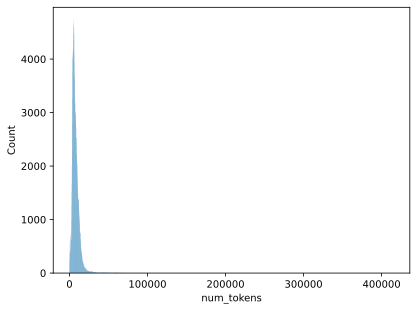

In [122]:
sns.histplot(df4_full['num_tokens'])

In [116]:
# We will remove articles with less than 1000 tokens
df4_full[df4_full['num_tokens']<=1000][['cleaned_text']].sample(5)

,cleaned_text
27675,"Artificial Intelligence ChipsMarket Growth, Size, Opportunities and Analysis Forecast 20212026UsJune 30, 2022Business Health Science Technology World Business Health Science Technology World Business Health Science Technology World"
35251,"Robot hand finger pointing, AIFree PhotorawpixelrawpixelHomeTopicsFreePremiumElementsFree FontsPublic DomainArtImagesTopicsBoardsImagesTopicsBoardsFlukeFree hand finger pointing, AI technology backgroundMoreFreeRoyalty Free PhotoInfoView LicenseJPEGTIFFSmallJPEG 1200 x 800 px300 dpiLargeJPEG 3500 x 2334 px300 dpiOriginalJPEG 4537 x 3025 px300 dpiTIFF 4537 x 3025 px300 dpi78.55 MB rawpixelSaveDownloadRobot hand finger pointing, AI technology backgroundMoreFlukeShare : Keywords :robotichand indication technologymechanicalrobot fingerautomation photo3d renderingaiautomation"
8822,How can engineering education embrace ChatGPT By treating it like a toolNewsBreakSign inHomeLocalHeadlinesvirusOriginalRecommendEntertainmentEntertainmentCelebritiesTVVideosMusicMoviesVisual ArtTV SeriesBooksLiteratureComicsTheaterDanceBehind Viral VideosPerforming ArtsTV ShowsPhotographyMuseumsDesignRock MusicHip HopPoliticsPoliticsU.S. PoliticsMilitaryCongressCourtsElectionsLawPresidential ElectionImmigrationPOTForeign PolicyHealthHealthPublic HealthHealth ServicesMental HealthDiseasesTreatmentsPharmaceuticalsWomens HealthCancerFood SafetyNutritionSportsSportsFootballNSoccerBaseballMLBCollege SportsPremier LeagueBasketballCombat SportsNBATennisMotorsportsGolfMLSHockeyWWELUFCUEFifestyleLifestyleFoodDrinksPetsBeautyFashionAnimalsShoppingHomeGardenRestaurantsHobbiesTravelApparelFitnessRecipesGamblingDrinksGardeningInterior DesignWildlifeWorkoutsLotteryCrimeSafetyPublic SafetyAccidentsLaw EnforcementTraffic ViolationsVandalismSocietySocietyEnvironmentReligionAdvocacyRelationshipsChar...
61982,Gartner: 4 trends driving nearterm Artificial Intelligence innovationCRN
2204,"Detect ChatGPT Content: DetectGPTMenu Submit your Product Latest Products Submit your story press release Free Book SummariesStoriesSubmit Product Detect ChatGPT Content: DetectGPTDetect ChatGPT ContentFind out if the s you browse contain AIgenerated content. Detect GPT scans the content of the web you are viewing and analyzes it to identify if any of the content has been generated using the GPT language model.0 0 0 Share 0 Tweet 0 Share 0Get itApril 28, 2023TomMore productsChatGPT on WhatsApp: Chatty CatEffortlessly craft engaging release notes with GPT3: ReleaseNote.AICreate content 10x faster with AI: JasperGet all the latest products in your Inboxto the newsletterNewsletter Email address: Leave this field empty if youre human:PrevPreviousInfluencer outreachlink building on autopilot: MentionedNextEmpowering Originality and Inspiring Authenticity: CopyleaksNext"


In [131]:
# We will remove articles with more than 50_000 tokens (mean is 8000 tokens)
df4_full[df4_full['num_tokens']>=40_000][['cleaned_text']].sample(3)

,cleaned_text
110602,"Archeology: Microsoft uses AI to digitally recreate the site of the first ever Olympic GamesDaily Mail OnlineHome U.K. News Sports U.S. Showbiz Femail Health Science Money Video Travel Shop DailyMailTV Latest Headlines NASA Apple Twitter Games My Profile LogoutFeedback Wednesday, Nov 10th 2021 10AM 62F 1PM 67F 5Day ForecastAdvertisement Visit as it stood more than 2,000 years ago Microsoft uses AI to digitally recreate the site of the first ever Olympic GamesCommon Grounds is a joint effort with the Hellenic Ministry of CultureSportMicrosoft and tech firm Iconem took thousands of photos of the siteAI then turned these into digital models, on which reconstructions were buildThe experience is available via web browser, as well as Android and iOS appsIt contains27 monuments including the Temple of Zeus and the StadiumThe first ever Olympic Games were held at back in the year 776 BCBy Ian Randall For MailonlinePublished:11:27 EST, 10 November 2021Updated:11:33 EST, 10 November 2021..."
6496,"Tesla to REVE sensors from new cars in a bet on cameras and AIamid scrutiny of crashesDaily Mail OnlineHome U.K. News Sports U.S. Showbiz Femail Health Science Money Video Travel Shop Latest HeadlinesNASAAppleTwitterGamesMy Profile LogoutFeedback Wednesday, Oct 5th 2022 1PM 53F 4PM 58F 5Day ForecastAdvertisement Tesla to REVE sensors from the vehicles selfdriving system and instead rely on eight cameras and artificial intelligence after intense scrutiny following series of crashesElon Musks company is removing ultrasonic sensors that can detect obstacles from its Autopilot system in favor of one based cameras and AIThe sensors, which emit highfrequency sounds that bounce off of objects, will be phased out of Model 3 and Model Y first, with other models impacted in 2023Tesla is facing intense regulatory and legal scrutiny at the federal and state level over a series of crashes involving its selfdriving systemMusk reportedly told the Autopilot team in 2021 that humans could drive wi..."
131596,ShotSpotter document reveals key human role in AI gunshot tech Skip to main contentSkip to main contentfor more free articles. Sign up for our newsletter to keep reading. Be the first to know Get local news delivered to your inbox Sign upAlready a r Sign in Terms of ServiceBack to homerPlease subscribe to keep reading. You can cancel at any time.Loadinghellp You have permission to edit this article.Edit Close 19Log InGuest Logout Read Todays Eedition News Local V19 Crime StateRegional GovernmentPolitics Business National Multimedia World News Tip Obituaries Share a story Recent Obituaries Find an Obituary Archives Opinion Submit a letter Letters Editorial GuestColumnists Sports High School College Musketeers Explorers Bandits National Professional Betting Entertainment ArtsTheatre Event Calendar Contests Comics Puzzles Columns Movies Music Television TV GuideLifestyles FoodCooking HealthFitness HomeGarden Life RelationshipsSpecial Occasions Special Sections Submit Announcement Peo...


In [128]:
df4_full=df4_full[df4_full['num_tokens']>=1_000]
df4_full=df4_full[df4_full['num_tokens']<=50_000]
df4_full.shape

(194894, 15)

In [140]:
%%time
df4_full.to_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data4_tokens.parquet')

CPU times: user 30.3 s, sys: 6.1 s, total: 36.4 s
Wall time: 1min 32s


---
### Implementing Keyword Analysis using RAKE

In [133]:
# %pip install --upgrade rake_nltk
from rake_nltk import Rake

In [134]:
r = Rake() # Uses stopwords for english from NLTK, and all puntuation characters.

def rake_implement(x,r):
    r.extract_keywords_from_text(x) # r.extract_keywords_from_text(<text to process>)
    return r.get_ranked_phrases() # r.get_ranked_phrases() # To get keyword phrases ranked highest to lowest.

In [138]:
# First checking on a subset
df4_samp=df4_full.sample(1000)
df4_samp['rake_phrases_articles']=df4_samp['cleaned_text'].apply(lambda x: rake_implement(x,r))

In [141]:
%%time
df4_full['rake_phrases_articles']=df4_full['cleaned_text'].apply(lambda x: rake_implement(x,r))

CPU times: user 24min 21s, sys: 4.31 s, total: 24min 25s
Wall time: 24min 25s


In [142]:
df4_full['rake_phrases_articles']

99        [burkert fluid control systems emerson electric co honeywell internationalkitz corporation rotork plc schlumberger limited tyco international ltd watts water technologies, opportunitiestrends 2024 rket rept2 weeks ago sawmill machinerymarket trends analysis 20192026 rket rept4 weeks ago starlink simulation produced low latency, technology subtractive additive stereolithography selective laser sintering fused deposition modeling ink jet printing techniques others global rapid prototyping market, unfavorable government policies 20182026 market forecast market size industry growth industry trends market report market share key players global market market sales industry analysis market outlookusrket rept artificial intelligence ai, starliners historic landing rket rept2 weeks ago global cereal ingredient market strategies assessment 2020archer daniels midland, light brown sugar market may see potentially high growth factors rket rept2 weeks ago, aimed 1 millionmile batteryrket r

In [ ]:
# df4_full['rake_phrases_articles']=df4_full['rake_phrases_articles'].apply(', '.join)

In [143]:
%%time
df4_full.to_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data4_tokens_rake.parquet')

CPU times: user 42.6 s, sys: 7.38 s, total: 49.9 s
Wall time: 1min 46s


------

In [8]:
df4_full=pd.read_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data4_tokens_rake.parquet')
df4_full.head()

,url,date,language,title,text,cleaned_text,article_source,clean_title,title_tokens,cleaned_text_tokens,year_pub,month,month-year,flag_relevant,num_tokens,rake_phrases_articles
99,https://fusionscienceacademy.com/artificial-in...,2020-01-30,en,Artificial Intelligence (AI) in Social Media ...,\n\nArtificial Intelligence (AI) in Social Med...,Artificial Intelligence AI in Social MediaMar...,2026 – Fusion Science Academy,Artificial Intelligence (AI) in Social Media ...,"['artificial', 'intelligence', 'ai', 'social',...","['artificial', 'intelligence', 'ai', 'social',...",2020,1,Jan 2020,1,22283,[burkert fluid control systems emerson electri...
115,https://health.economictimes.indiatimes.com/ne...,2020-01-10,en,artificial intelligence: Researchers develop A...,\n\nartificial intelligence: Researchers devel...,artificial intelligence: Researchers develop ...,None,artificial intelligence: Researchers develop A...,"['artificial', 'intelligence', 'researchers', ...","['artificial', 'intelligence', 'researchers', ...",2020,1,Jan 2020,1,8087,[economic times ethealthworldhome news hospita...
117,https://heraldpublicist.com/bet-gil-on-ai-fina...,2020-01-15,en,Bet Gil on AI Final Fantasy Tactics Matches in...,\n\nBet Gil on AI Final Fantasy Tactics Matche...,Bet Gil on AI Final Fantasy Tactics Matches i...,Herald Publicist,Bet Gil on AI Final Fantasy Tactics Matches in...,"['bet', 'gil', 'ai', 'final', 'fantasy', 'tact...","['bet', 'gil', 'ai', 'final', 'fantasy', 'tact...",2020,1,Jan 2020,1,4458,[hilarious twitch streamnewstechnologycricketp...
119,https://honestversion.com/2020/01/24/growth-of...,2020-01-24,en,Growth of Cloud Telecommunication AI market in...,\n\nGrowth of Cloud Telecommunication AI marke...,Growth of Cloud Telecommunication AI market i...,Honest Version,Growth of Cloud Telecommunication AI market in...,"['growth', 'cloud', 'ai', 'market', 'global', ...","['growth', 'cloud', 'ai', 'market', 'global', ...",2020,1,Jan 2020,1,6048,[cloud telecommunication ai market strategic a...
156,https://marketresearchsheets.com/2020/01/21/gl...,2020-01-21,en,Global Nasogastric Tubes Market 2020- Bard ...,\nGlobal Nasogastric Tubes Market 2020- Bar...,Global Nasogastric Tubes Market 2020Bard Medi...,Market Research Sheets,Global Nasogastric Tubes Market 2020- Bard ...,"['global', 'nasogastric', 'tubes', 'market', '...","['global', 'nasogastric', 'tubes', 'market', '...",2020,1,Jan 2020,1,6345,[market research sheets tagsnasogastric tubes ...


In [9]:
df4_full['rake_phrases_joined']=df4_full['rake_phrases_articles'].apply(', '.join)

In [13]:
pd.options.display.max_colwidth=1000
df4_full[['rake_phrases_articles','rake_phrases_joined']].head(2)

,rake_phrases_articles,rake_phrases_joined
99,"[burkert fluid control systems emerson electric co honeywell internationalkitz corporation rotork plc schlumberger limited tyco international ltd watts water technologies, opportunitiestrends 2024 rket rept2 weeks ago sawmill machinerymarket trends analysis 20192026 rket rept4 weeks ago starlink simulation produced low latency, technology subtractive additive stereolithography selective laser sintering fused deposition modeling ink jet printing techniques others global rapid prototyping market, unfavorable government policies 20182026 market forecast market size industry growth industry trends market report market share key players global market market sales industry analysis market outlookusrket rept artificial intelligence ai, starliners historic landing rket rept2 weeks ago global cereal ingredient market strategies assessment 2020archer daniels midland, light brown sugar market may see potentially high growth factors rket rept2 weeks ago, aimed 1 millionmile batteryrket rept3 w...","burkert fluid control systems emerson electric co honeywell internationalkitz corporation rotork plc schlumberger limited tyco international ltd watts water technologies, opportunitiestrends 2024 rket rept2 weeks ago sawmill machinerymarket trends analysis 20192026 rket rept4 weeks ago starlink simulation produced low latency, technology subtractive additive stereolithography selective laser sintering fused deposition modeling ink jet printing techniques others global rapid prototyping market, unfavorable government policies 20182026 market forecast market size industry growth industry trends market report market share key players global market market sales industry analysis market outlookusrket rept artificial intelligence ai, starliners historic landing rket rept2 weeks ago global cereal ingredient market strategies assessment 2020archer daniels midland, light brown sugar market may see potentially high growth factors rket rept2 weeks ago, aimed 1 millionmile batteryrket rept3 we..."
115,"[economic times ethealthworldhome news hospitalspharmamedical devicesdiagnosticspolicyindustrypeople movementfinancial resultsinterviews blogs feature features trends startups medical specialties oncology cardiology neurology oral care diabetology dataanalytics social analytics data reports healthtv brand solutions hospital awards scaling excellence, kk narayananfeatures industryspeakdataanalyticshealthtvwebinarseventsopinionsinterviewsinnovationstrendsstartupsoncologycardiologyneurologyoral carediabetologydatareportswebcastother b2b news sites retail newsauto newstelecom newsenergy newsit newsreal estate newsmarketingadvertising newstechnology newscfo newsit security newsbfsi newsgovernment newsusadvertise, healthcarehospitals pharma medical devices ethealthworld fertility conclave diagnostics policy slideshows industry people movement world heart day financial results, et healthworldsign insign upws sitesretail news auto news telecom news energy news, ivf schneider electric reinv...","economic times ethealthworldhome news hospitalspharmamedical devicesdiagnosticspolicyindustrypeople movementfinancial resultsinterviews blogs feature features trends startups medical specialties oncology cardiology neurology oral care diabetology dataanalytics social analytics data reports healthtv brand solutions hospital awards scaling excellence, kk narayananfeatures industryspeakdataanalyticshealthtvwebinarseventsopinionsinterviewsinnovationstrendsstartupsoncologycardiologyneurologyoral carediabetologydatareportswebcastother b2b news sites retail newsauto newstelecom newsenergy newsit newsreal estate newsmarketingadvertising newstechnology newscfo newsit security newsbfsi newsgovernment newsusadvertise, healthcarehospitals pharma medical devices ethealthworld fertility conclave diagnostics policy slideshows industry people movement world heart day financial results, et healthworldsign insign upws sitesretail news auto news te

In [ ]:
news_df[['text', 'rake_phrases']][news_df['rake_phrases'].str.contains("camry", na=False)].head(5)

In [22]:
tops_relevant=[' artificial ',' intelligence ',' machine ',' ai ',' ml ',' chatgpt ',' openai ',' llm ',' analytics ',' gpt ']
df4_samp=df4_full[df4_full['rake_phrases_joined'].str.contains('|'.join(tops_relevant), na=False, regex=True)]

In [24]:
print("initial dataset:",df4_full.shape)
print("filtered dataset:",df4_samp.shape)

initial dataset: (194894, 17)
filtered dataset: (186815, 17)


In [25]:
df4_samp.head(3)

,url,date,language,title,text,cleaned_text,article_source,clean_title,title_tokens,cleaned_text_tokens,year_pub,month,month-year,flag_relevant,num_tokens,rake_phrases_articles,rake_phrases_joined
99,https://fusionscienceacademy.com/artificial-intelligence-ai-in-social-media-market-to-witness-slow-growth-owing-to-unfavorable-government-policies-2018-2026/,2020-01-30,en,Artificial Intelligence (AI) in Social Media Market to Witness Slow Growth Owing to Unfavorable Government Policies 2018 – 2026 – Fusion Science Academy,"\n\nArtificial Intelligence (AI) in Social Media Market to Witness Slow Growth Owing to Unfavorable Government Policies 2018 – 2026 – Fusion Science Academy\nAbout Us\nOur Writers\nContact Us\nTerms and Conditions\nPrivacy Policy\nJoin Our Newsletter\n \n\n\nConnect with us\n \n \n\nFusion Science Academy\n\nArtificial Intelligence (AI) in Social Media Market to Witness Slow Growth Owing to Unfavorable Government Policies 2018 – 2026\nMarket Forecast\nMarket Size\nIndustry Growth\nIndustry Trends\nMarket Report\nMarket Share\nKey Players\nGlobal Market\nMarket Sales\nIndustry Analysis\nMarket Outlook\nContact Us\n \n\n \nMARKET REPORT\nArtificial Intelligence (AI) in Social Media Market to Witness Slow Growth Owing to Unfavorable Government Policies 2018 – 2026\nPublished 48 seconds ago on January 30, 2020\nBy [email protected] \nLatest report on global Artificial Intelligence (AI) in Social Media market by TMR\nAnalysts at TMR find that the global Artificial Intelligence (AI) i...","Artificial Intelligence AI in Social MediaMarket to Witness Slow Growth Owing to Unfavorable Government Policies 20182026Fusion Science AcademyOur WritersUs Terms and ConditionsJoin Our NewsletterConnect with usFusion Science Academy Artificial Intelligence AI in Social MediaMarket to Witness Slow Growth Owing to Unfavorable Government Policies 20182026 Market Forecast Market Size Industry Growth Industry Trends Market Report Market Share Key Players Global Market Market Sales Industry Analysis Market OutlookUsRKET REPT Artificial Intelligence AI in Social MediaMarket to Witness Slow Growth Owing to Unfavorable Government Policies 20182026 Published 48 seconds ago on January 30, 2020 By emailprotectedLatest report on global Artificial Intelligence AI in Social Media market by TMR Analysts at TMR find that the global Artificial Intelligence AI in Social Media market has been evolving at a GR of xx during the historic period 20142018. The market study suggests that the global market...",2026 – Fusion Science Academy,Artificial Intelligence (AI) in Social Media Market to Witness Slow Growth Owing to Unfavorable Government Policies 2018,"['artificial', 'intelligence', 'ai', 'social', 'media', 'market', 'witness', 'slow', 'growth', 'owing', 'unfavorable', 'government', 'policies']","['artificial', 'intelligence', 'ai', 'social', 'mediamarket', 'witness', 'slow', 'growth', 'owing', 'unfavorable', 'government', 'policies', 'fusion', 'science', 'academyour', 'writersus', 'terms', 'conditionsjoin', 'usfusion', 'science', 'academy', 'artificial', 'intelligence', 'ai', 'social', 'mediamarket', 'witness', 'slow', 'growth', 'owing', 'unfavorable', 'government', 'policies', 'market', 'forecast', 'market', 'size', 'industry', 'growth', 'industry', 'trends', 'market', 'report', 'market', 'share', 'key', 'players', 'global', 'market', 'market', 'sales', 'industry', 'analysis', 'market', 'outlookusmarket', 'report', 'artificial', 'intelligence', 'ai', 'social', 'mediamarket', 'witness', 'slow', 'growth', 'owing', 'unfavorable', 'government', 'policies', 'published', 'seconds', 'ago', 'january', 'report', 'global', 'artificial', 'intelligence', 'ai', 'social', 'media', 'market', 'tmr', 'analysts', 'tmr', 'global', 'artificial', 'intelligence', 'ai', 'social', 'media', 'mark...",2020,1,Jan 2020,1,22283,"[burkert fluid control systems emerson electric co honeywell internationalkitz corporation rotork plc schlumberger limited tyco international ltd watts

In [26]:
df4_samp.to_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data4_filtered.parquet')